In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trade = 'BTC'
based_on = 'SIL'

columns = [
            'Date', 
            'Open', 'Close',
            'Low', 'High',
           ]

In [3]:
def to_numeric(df, columns=columns):
    cols_present = columns.copy()
    for column in columns:
        if column not in df.columns:
            cols_present.remove(column)
            continue
        if column == 'Date':
            continue
        df[column] = df[column].astype(str)
        if '%' in df[column][0]:
            df[column] = df[column].str.replace('%','')
            df[column] = pd.to_numeric(df[column].str.replace(',','')) / 100
        else:
            df[column] = pd.to_numeric(df[column].str.replace(',',''))
    
    return df[cols_present]


def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

In [4]:
BTC = pd.read_csv('Data/BTC.csv')
BTC['Date'] = pd.to_datetime(BTC['Date'])
BTC = BTC.sort_values('Date')\
        .reset_index()

BTC['Close'] = BTC['Price']
BTC = to_numeric(BTC)
BTC.columns = ['Date'] + [
                'BTC.' + column
                for column in BTC.columns
                if column != "Date"
    ]

SIL = pd.read_csv('Data/SI=F.csv')\
        .dropna()\
        .reset_index().drop('index', axis=1)
SIL['Date'] = pd.to_datetime(SIL['Date'])
SIL = to_numeric(SIL)
SIL.columns = ['Date'] + [
                'SIL.' + column
                for column in SIL.columns
                if column != "Date"
    ]

merged = pd.merge(BTC, SIL, how='inner').dropna()

In [5]:
def strategy(df, trade, based_on):
    df[f'{based_on}.OvernightReturn'] = df[f"{based_on}.Open"] / df[f"{based_on}.Close"].shift(1) - 1
    df[f'{trade}.DailyReturn'] = df[f'{trade}.Close'].pct_change().fillna(0)

    returns = (df[f'{based_on}.OvernightReturn'] > 0)\
                    .astype(int) \
                * df[f'{trade}.DailyReturn']
    return np.array(returns, dtype=np.longdouble)

In [6]:
strategy_returns = pd.DataFrame({
                'Returns': strategy(merged, 
                                trade=trade, 
                                based_on=based_on),
                'Date': merged['Date']}).set_index('Date')

strategy_returns["Cumulative"] = (1 + strategy_returns["Returns"]).cumprod()

# Returns
strategy_returns["Year"] = strategy_returns.index.year
strategy_yearly_returns = (strategy_returns.groupby("Year")["Cumulative"].last() \
                    / strategy_returns.groupby("Year")["Cumulative"].first() - 1) * 100

# MDD
strategy_yearly_drawdowns = strategy_returns.groupby("Year")["Returns"].apply(max_drawdown) * 100

strategy_table = pd.DataFrame({
    ('Our Strategy', 'Returns'): strategy_yearly_returns,
    ('Our Strategy', 'Max Drawdown'): strategy_yearly_drawdowns})

In [7]:
bnh_returns = pd.DataFrame({
                'Returns': BTC[f'{trade}.Close'].pct_change().fillna(0),
                'Date': BTC['Date']}).set_index('Date')

bnh_returns["Cumulative"] = (1 + bnh_returns["Returns"]).cumprod()

# Returns
bnh_returns["Year"] = bnh_returns.index.year
bnh_yearly_returns = (bnh_returns.groupby("Year")["Cumulative"].last() \
                    / bnh_returns.groupby("Year")["Cumulative"].first() - 1) * 100

# MDD
bnh_yearly_drawdowns = bnh_returns.groupby("Year")["Returns"].apply(max_drawdown) * 100

# Create a table for yearly returns
bnh_table = pd.DataFrame({
    ('Buy & Hold', 'Returns'): bnh_yearly_returns,
    ('Buy & Hold', 'Max Drawdown'): bnh_yearly_drawdowns})

<Figure size 1200x1000 with 0 Axes>

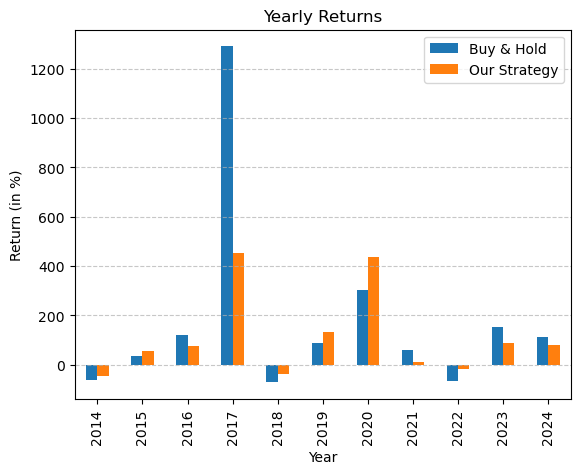

In [8]:
yearly_returns = pd.merge(bnh_yearly_returns.rename('Buy & Hold').reset_index(),
                           strategy_yearly_returns.rename('Our Strategy').reset_index(),
                            how='inner').dropna()
# Plot Yearly Returns
plt.figure(figsize=(12, 10))

yearly_returns.plot(x='Year', 
        kind='bar', 
        stacked=False, 
        title='Yearly Returns')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Return (in %)')
plt.savefig(f'Output/Trade {trade} on {based_on}/fig-Returns.png', bbox_inches='tight')
plt.show()

<Figure size 1200x1000 with 0 Axes>

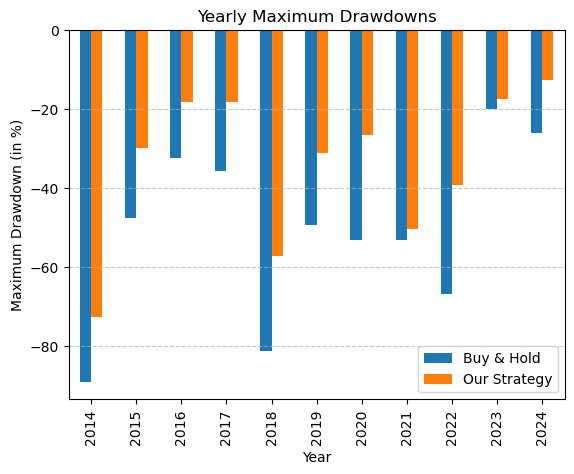

In [9]:
yearly_mdd = pd.merge(bnh_yearly_drawdowns.rename('Buy & Hold').reset_index(),
                           strategy_yearly_drawdowns.rename('Our Strategy').reset_index(),
                            how='inner').dropna()
# Plot Yearly Returns
plt.figure(figsize=(12, 10))

yearly_mdd.plot(x='Year', 
        kind='bar', 
        stacked=False, 
        title='Yearly Maximum Drawdowns')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Maximum Drawdown (in %)')
plt.savefig(f'Output/Trade {trade} on {based_on}/fig-MDD.png', bbox_inches='tight')
plt.show()

Buy & Hold: 11589.680107856328
Our Strategy: 23048.767789285477


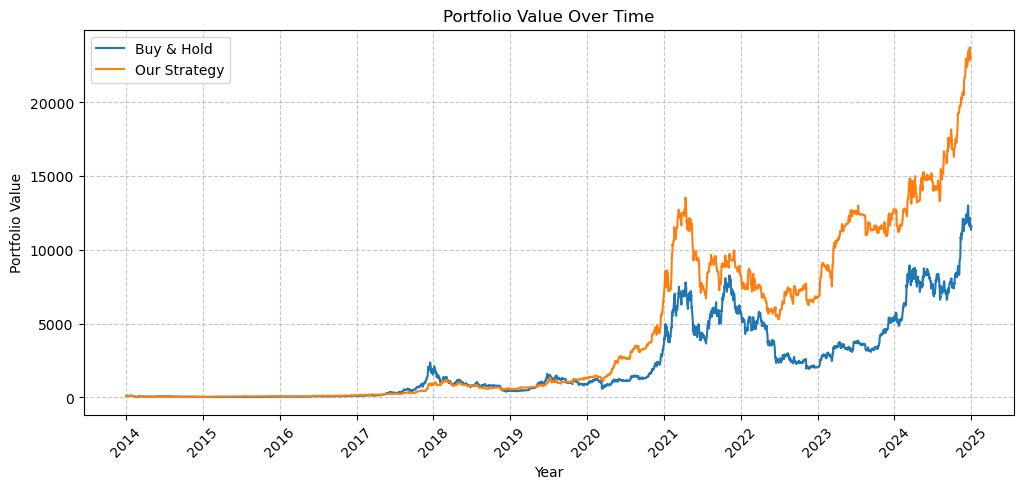

In [10]:
import matplotlib.dates as mdates

initial_value = 100
plt.figure(figsize=(12, 5))

# Compute the portfolio value over time
df = bnh_returns
df["Portfolio Value"] = initial_value * (1 + df["Returns"]).cumprod()
plt.plot(df.index,
         df["Portfolio Value"],
         label="Buy & Hold")
print(f"Buy & Hold: {list(df['Portfolio Value'])[-1]}")

df = strategy_returns
df["Portfolio Value"] = initial_value * (1 + df["Returns"]).cumprod()
plt.plot(df.index,
         df["Portfolio Value"],
         label="Our Strategy")
print(f"Our Strategy: {list(df['Portfolio Value'])[-1]}")

# Format the x-axis to show every year
plt.xlabel("Year")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis to show every year
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Set major ticks every year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as year
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.savefig(f'Output/Trade {trade} on {based_on}/fig-Portfolio Value.png', bbox_inches='tight')
plt.show()

In [11]:
returns_table = pd.merge(strategy_table, bnh_table, left_index=True, right_index=True)
returns_table = returns_table.round(2)
returns_table.to_excel(f'Output/Trade {trade} on {based_on}/table-Comparison.xlsx')